# Bangla Digit Recognition

### Import

In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [19]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from sklearn import metrics
from sklearn.utils import shuffle

In [3]:
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from skimage.feature import hog, local_binary_pattern

## Functions

### Read Images:

In [4]:
def read_images(path):
    images = []
    labels = []
    height = 32
    width = 32
    for file_name in os.listdir(path):
        file_path = path + '/' + file_name
        for img_name in os.listdir(file_path):
            if not img_name.startswith('.'):
                if img_name.endswith('.png'):
                    img = cv2.imread(file_path + '/' + img_name)
                    new_img = cv2.resize(img, (height, width))
                    images.append(new_img)
                    labels.append(file_name)
    return np.array(images), np.array(labels)

### Save / Load Extracted Features:

In [5]:
def save_feature(feature, name):
    # saving all our feature vectors in pickled file
    with open('cache/' + name + '.pkl', 'wb') as fp:
        pickle.dump(csr_matrix(feature), fp)
    
    print(f'Feature saved with name cache/{name}.pkl')

def load_feature(feature_name):
    return pickle.load(open(feature_name, 'rb')).A

### Save / Load PCA fit components:

In [6]:
def save_pca(pca_data, name):
    pickle.dump(pca_data, open('pca/' + name + '.pkl', 'wb'))
    print(f'PCA data saved with name pca/{name}.pkl')
    
def load_pca(pca_name):
    return pickle.load(open(pca_nam, 'rb')).A

### Save / Load Trained model:

In [7]:
def save_model(model):
    filename = input('Enter model file name:')
    pickle.dump(model, open('models/'+filename + '.pkl', 'wb'))
    print(f'Successfully saved model in models/{filename}.pkl')

def load_model(model_name):
    return pickle.load(open(model_name, 'rb'))

### Features:

### HOG Features:

In [8]:
def get_hog(images, name='hog', save=False):
    cell_size = (4, 4)    # h x w in pixels
    block_size = (2, 2)     # h x w in cells
    nbins = 9
    
    # winSize is the size of the image cropped to an multiple of the cell size
    # cell_size is the size of the cells of the img patch over which to calculate the histograms
    # block_size is the number of cells which fit in the patch
    hog_desc = cv2.HOGDescriptor(_winSize=(images[0].shape[1] // cell_size[1] * cell_size[1],
                                              images[0].shape[0] // cell_size[0] * cell_size[0]),
                                    _blockSize=(block_size[1] * cell_size[1],
                                                block_size[0] * cell_size[0]),
                                    _blockStride=(cell_size[1], cell_size[0]),
                                    _cellSize=(cell_size[1], cell_size[0]),
                                    _nbins=nbins)
    
    def get_image_hog(image):
        # HOG feature
        f = hog_desc.compute(image)
        
        res = np.array(f)
        return res.flatten()
    
    # HOG for all images
    features = []
    for i, img in enumerate(images):
        f = get_image_hog(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
        features.append(f)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
    
    return result

### Local Binary Pattern (LBP) Features:

In [9]:
def get_lbp(images, name='lbp', save=False):
    result = np.array([local_binary_pattern(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 10, 3).flatten() for img in images])
    
    if save:
        save_feature(result, name)
        
    return result

### SIFT Features:

In [10]:
def get_sift(images, name='sift', save=False):
    
    # SIFT descriptor for 1 image
    def get_image_sift(image, vector_size=15):
        alg = cv2.xfeatures2d.SIFT_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 128
        needed_size = (vector_size * 128)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SIFT descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_sift(img)
        features.append(dsc)

    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

### Flattened Image feature:

In [11]:
def get_flattened(images, name='flatten', save=False):
    
    def get_image_flatten(image):
        return cv2.cvtColor(image,  cv2.COLOR_RGB2GRAY).flatten()
        
        
    features = []
    for i, img in enumerate(images):
        dsc = get_image_flatten(img)
        features.append(dsc)

    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

### Combine Features:

In [12]:
def combine_features(features, horizontal=True):
    """
    Array of features [f1, f2, f3] where each fi is a feature set 
    eg. f1=rgb_flat, f2=SIFT, etc.
    """
    if horizontal:
        return np.hstack(features)
    else:
        return np.vstack(features)

### Normalize features:

In [13]:
def norm_features_minmax(train, test):
    min_max_scaler = preprocessing.MinMaxScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

In [14]:
def norm_features_zscore(train, test):
    min_max_scaler = preprocessing.StandardScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

### Classifiers:

In [15]:
def train_model(train_x, train_y, model_name='NB', validation=None):
    """
    Possible model names: ['RF', 'SVM', 'XGB', 'KNN']
    default = 'NB'
    
    validation: (val_x, val_y) tupple for validation accuracy score.
    
    return: trained model
    """
    model = None
    if model_name == 'SVM':
        model = svm.SVC(gamma='scale', probability=True)
    elif model_name == 'XGB':
        model = XGBClassifier(n_estimators=200, max_depth=5, n_jobs=2)
#         model = XGBClassifier()
    elif model_name == 'RF':
        model = RandomForestClassifier(n_estimators=200, max_depth=10)
    elif model_name == 'KNN':
        model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
    else:
        model = GaussianNB()
    
    model.fit(train_x, train_y)
    
    if validation is not None:
        y_hat = model.predict(validation[0])
        acc = metrics.accuracy_score(validation[1], y_hat)
        print(f"Validation Accuracy in '{model_name}' = {acc}")
        cm = metrics.confusion_matrix(validation[1], y_hat)
        print(cm)
        recall = cm[0][0] / (cm[0][0] + cm[0][1])
        precision = cm[0][0] / (cm[0][0] + cm[1][0])
        f1 = 2*(precision*recall)/(precision+recall)
        print(f"Recall in '{model_name}' = {recall}")
        print(f"Precision in '{model_name}' = {precision}")
        print(f"F1 Score in '{model_name}' = {f1}")
               
    return model

## Main Cells

### Load Images:

In [12]:
full_data_x, full_data_y = read_images('BanglaLekha-Isolated/Images')

In [13]:
print("dataset size : ", full_data_x.shape, full_data_y.shape)

dataset size :  (166105, 32, 32, 3) (166105,)


In [14]:
print("One Image size: ", full_data_x[2].shape)

One Image size:  (32, 32, 3)


### train and validation set:

In [17]:
train_imgs, val_imgs, train_y, val_y = train_test_split(full_data_x, full_data_y, test_size=0.2)

In [18]:
print("Train data :", train_imgs.shape, "       Label: ", train_y.shape) 
print("Validation data :", val_imgs.shape, "   Label: ", val_y.shape) 

Train data : (132884, 32, 32, 3)        Label:  (132884,)
Validation data : (33221, 32, 32, 3)    Label:  (33221,)


### Save train, validation data:

In [21]:
np.save('data/train_imgs.npy', train_imgs)
np.save('data/train_y.npy', train_y)
np.save('data/val_imgs.npy', val_imgs)
np.save('data/val_y.npy', val_y)

### Load

In [22]:
train_imgs = np.load('data/train_imgs.npy')
train_y = np.load('data/train_y.npy')
val_imgs = np.load('data/val_imgs.npy')
val_y = np.load('data/val_y.npy')

In [5]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape

((132884, 32, 32, 3), (33221, 32, 32, 3), (132884,), (33221,))

#### Data Visualization:

8


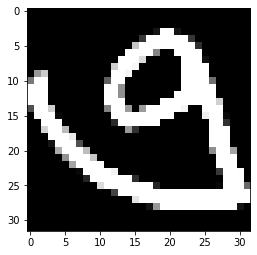

In [6]:
plt.figure(figsize=(4,10))
plt.imshow(train_imgs[0])
print(train_y[0])

### Features:

### HOG features:

In [40]:
hog_train = get_hog(train_imgs, name='hog_train', save=True)
hog_val = get_hog(val_imgs, name='hog_val', save=True)

Feature saved with name cache/hog_train.pkl
Feature saved with name cache/hog_val.pkl


In [14]:
hog_train = load_feature('cache/hog_train.pkl')
hog_val = load_feature('cache/hog_val.pkl')

In [15]:
hog_train.shape, hog_val.shape

((132884, 1764), (33221, 1764))

### LBP features:

In [8]:
lbp_train = get_lbp(train_imgs, name='lbp_train', save=True)
lbp_val = get_lbp(val_imgs, name='lbp_val', save=True)

Feature saved with name cache/lbp_train.pkl
Feature saved with name cache/lbp_val.pkl


In [16]:
lbp_train = load_feature('cache/lbp_train.pkl')
lbp_val = load_feature('cache/lbp_val.pkl')

In [17]:
lbp_train.shape, lbp_val.shape

((132884, 1024), (33221, 1024))

### SIFT features:

In [9]:
sift_train = get_sift(train_imgs, name='sift_train', save=True)
sift_val = get_sift(val_imgs, name='sift_val', save=True)

Feature saved with name cache/sift_train.pkl
Feature saved with name cache/sift_val.pkl


In [13]:
sift_train = load_feature('cache/sift_train.pkl')
sift_val = load_feature('cache/sift_val.pkl')

In [ ]:
sift_train.shape, sift_val.shape

### Flattened image:

In [15]:
flatten_train = get_flattened(train_imgs, name='flatten_train', save=True)
flatten_val = get_flattened(val_imgs, name='flatten_val', save=True)

Feature saved with name cache/flatten_train.pkl
Feature saved with name cache/flatten_val.pkl


In [16]:
flatten_train = load_feature('cache/flatten_train.pkl')
flatten_val = load_feature('cache/flatten_val.pkl')

In [17]:
flatten_train.shape, flatten_val.shape

((132884, 1024), (33221, 1024))

### Reduce Features by PCA:

#### HOG PCA:

In [21]:
# norm_hog_train, norm_hog_val = norm_features_minmax(hog_train, hog_val)
norm_hog_train, norm_hog_val = norm_features_zscore(hog_train, hog_val)

In [22]:
pca = PCA(n_components=10)
pca_hog_train = pca.fit_transform(norm_hog_train)
pca_hog_val = pca.transform(norm_hog_val)

In [23]:
np.save('cache/pca_hog_train.npy', pca_hog_train)
np.save('cache/pca_hog_val.npy', pca_hog_val)

In [19]:
pca_hog_train = np.load('cache/pca_hog_train.npy')
pca_hog_val = np.load('cache/pca_hog_val.npy')

In [20]:
pca_hog_train.shape, pca_hog_val.shape

((132884, 10), (33221, 10))

#### LBP PCA:

In [21]:
# norm_lbp_train, norm_lbp_val = norm_features_minmax(lbp_train, lbp_val)
norm_lbp_train, norm_lbp_val = norm_features_zscore(lbp_train, lbp_val)

In [22]:
pca = PCA(n_components=10)
pca_lbp_train = pca.fit_transform(norm_lbp_train)
pca_lbp_val = pca.transform(norm_lbp_val)

In [23]:
np.save('cache/pca_lbp_train.npy', pca_lbp_train)
np.save('cache/pca_lbp_val.npy', pca_lbp_val)

In [21]:
pca_lbp_train = np.load('cache/pca_lbp_train.npy')
pca_lbp_val = np.load('cache/pca_lbp_val.npy')

In [22]:
pca_lbp_train.shape, pca_lbp_val.shape

((132884, 10), (33221, 10))

#### SIFT PCA:

In [26]:
# norm_sift_train, norm_sift_val = norm_features_minmax(sift_train, sift_val)
norm_sift_train, norm_sift_val = norm_features_zscore(sift_train, sift_val)

In [27]:
pca = PCA(n_components=5)
pca_sift_train = pca.fit_transform(norm_sift_train)
pca_sift_val = pca.transform(norm_sift_val)

In [28]:
np.save('cache/pca_sift_train.npy', pca_sift_train)
np.save('cache/pca_sift_val.npy', pca_sift_val)

In [23]:
pca_sift_train = np.load('cache/pca_sift_train.npy')
pca_sift_val = np.load('cache/pca_sift_val.npy')

In [24]:
pca_sift_train.shape, pca_sift_val.shape

((132884, 5), (33221, 5))

## Classification:

In [23]:
features_train_x, features_val_x, features_train_y, features_val_y = flatten_train, flatten_val, train_y, val_y
features_train_x, features_train_y = shuffle(features_train_x, features_train_y)

#### Models:

In [25]:
model1 = train_model(np.array(features_train_x), features_train_y, model_name='RF', validation=(features_val_x, features_val_y))

Validation Accuracy in 'RF' = 0.3317479907287559
[[ 47   0   1 ...   0   0   0]
 [  2 183   7 ...   0   0   1]
 [  0   2 265 ...   0   0  11]
 ...
 [  2   0   1 ...   9   1   2]
 [  0   2  22 ...   0  92   3]
 [  0   0  44 ...   0   4 173]]
Recall in 'RF' = 1.0
Precision in 'RF' = 0.9591836734693877
F1 Score in 'RF' = 0.9791666666666666


In [ ]:
model2 = train_model(np.array(features_train_x), features_train_y, model_name='SVM', validation=(features_val_x, features_val_y))

In [ ]:
model6 = train_model(np.array(features_train_x), features_train_y, model_name='XGB', validation=(features_val_x, features_val_y))

In [ ]:
model7 = train_model(np.array(features_train_x), features_train_y,, model_name='KNN', validation=(features_val_x, features_val_y))